In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm

from agent import model
from agent import dhp as DHP

In [2]:
def reference_state(current_state):
    y_pos = current_state[1]
    if y_pos > 0.25:
        ref_state = [0, 0.25, 0, -0.5, 0, 0, 0, 0]
    else:
        ref_state = [0, 0, 0, -0.15, 0, 0, 0, 0]
    return ref_state

# Example of Controlling LunarLander v2
Observation space:
[x, y, V_x, V_y, angle, angular velocity, left leg contact, right leg contact]

In [3]:
env = gym.make(
    "LunarLander-v2", continuous = True
)
init_condition = env.reset()
state_size = len(init_condition)
action_size = int(env.action_space.shape[0])

X, U, R, errors = [], [], [], []
t0 = 0
tn = 30
dt = 0.01
t = np.arange(t0, tn, dt)

# run single episode
for i in range(1,len(t)):
    action = [0,0.4]
    state, reward, done, _, _= env.step(action)
    X.append(state)
    U.append(action)
    R.append(reward)
    errors.append(np.abs(state - reference_state(state)))
    if done: 
        t = t[:i]
        break
action_size

2

## Plotting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


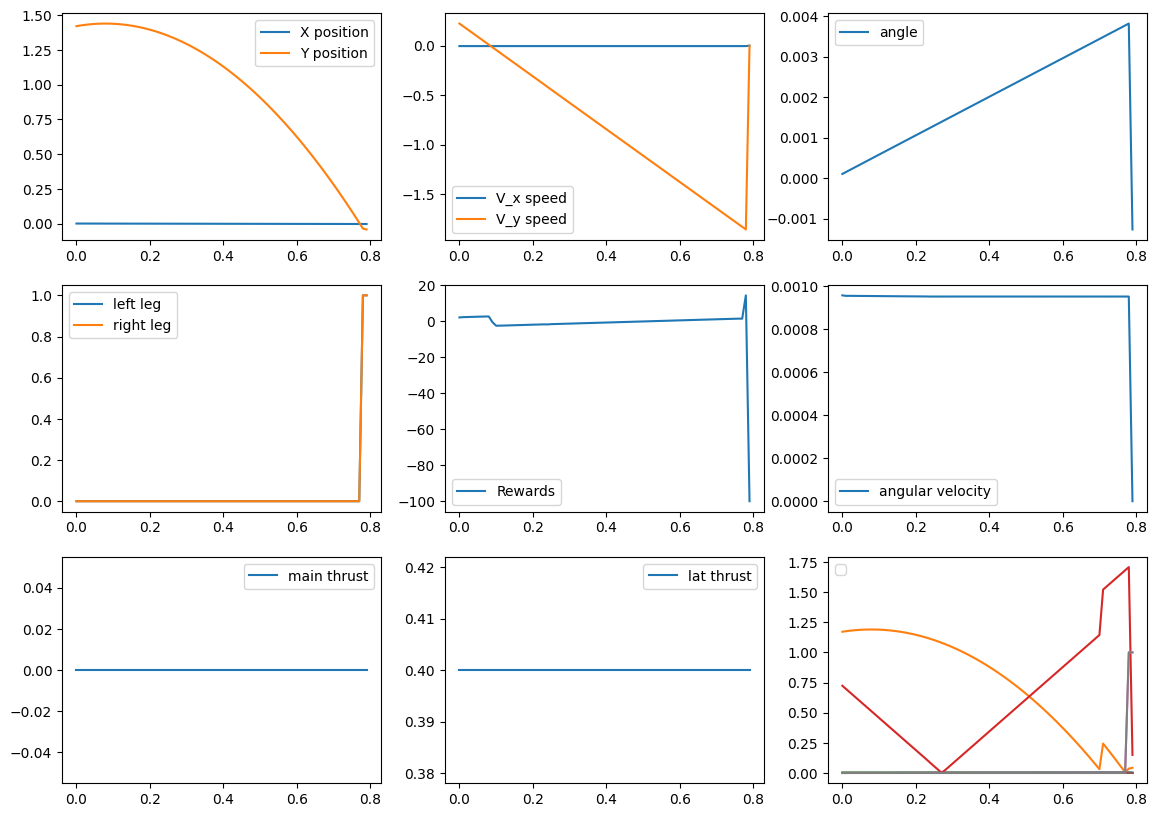

In [4]:
fig, axis = plt.subplots(3,3, figsize=(14,10))
axis[0, 0].plot(t, [i[0] for i in X], label="X position")
axis[0, 0].plot(t, [i[1] for i in X], label="Y position")
axis[0, 0].legend()

axis[0, 1].plot(t, [i[2] for i in X], label="V_x speed")
axis[0, 1].plot(t, [i[3] for i in X], label="V_y speed")
axis[0, 1].legend()

axis[0,2].plot(t, [i[4] for i in X], label="angle")
axis[0,2].legend()

axis[1,2].plot(t, [i[5] for i in X], label="angular velocity")
axis[1,2].legend()

axis[1,0].plot(t, [i[6] for i in X], label="left leg")
axis[1,0].plot(t, [i[7] for i in X], label="right leg")
axis[1,0].legend()

axis[1,1].plot(t, R, label="Rewards")
axis[1,1].legend()

axis[2,0].plot(t, [i[0] for i in U], label="main thrust")
axis[2,0].legend()
axis[2,1].plot(t, [i[1] for i in U], label="lat thrust")
axis[2,1].legend()

axis[2,2].plot(t, errors)
axis[2,2].legend()


# DHP LunarLander

In [5]:
TENSORBOARD_DIR = './logs/tensorboard/DHP/'

env = gym.make(
    "LunarLander-v2", continuous = True
)
init_condition = env.reset()[0]
state_size = len(init_condition)
action_size = int(env.action_space.shape[0])
TRACKED = [True for i in init_condition]
STATE_ERROR_WEIGHTS = [1, 1, 1, 1, 10, 10, 1, 1]

t0 = 0
tn = 30
dt = 0.01
t = np.arange(t0, tn, dt)

In [6]:
ac_kwargs = {
        # Arguments for all model types
        'state_size': state_size,
        'action_size': action_size,
        'predict_delta': False,
        # Neural Network specific args:
        'hidden_layer_size': [100, 100, 100],
        'activation': tf.nn.relu,
        # RLS specific args:
        'gamma': 0.9995,
        'covariance': 100,
        'constant': True,
        # LS specific args:
        'buffer_length': 10
}
ac_model = model.RecursiveLeastSquares(**ac_kwargs)
# todo continue actor and critic breakdown

In [7]:
lr_critic = 0.1
lr_actor = 0.05
kwargs = {
    'input_size': [state_size, state_size],                     # [Aircraft state size, Number of tracked states]
    'output_size': action_size,                                         # Actor output size (Critic output is dependend only on aircraft state size)
    'hidden_layer_size': [50, 50, 50],                                    # List with number of nodes per layer, number of layers is variable
    'kernel_stddev': 0.1,                                               # Standard deviation used in the truncated normal distribution to initialize all parameters
    'lr_critic': 0.1,                                                   # Learn rate Critic
    'lr_actor': 0.05,                                                   # Learn rate Actor
    'gamma': 0.4,                                                       # Discount factor
    'use_bias': False,                                                  # Use bias terms (only if you train using batched data)
    'split': False,                                                      # Split architechture of the actor, if False, a single fully connected layer is used.
    'target_network': False,                                             # Use target networks 
    'tau': 0.001,                                                       # Target network time constant 
    'activation': tf.keras.layers.Activation('relu'),
    'log_dir': TENSORBOARD_DIR,                                         # Where to save checkpoints
    'use_delta': (False, TRACKED)                                       # (True, TRACKED) used 's = [x, (x - x_ref)]' || (False, None) uses 's = [x, x_ref]' 
}
agent = DHP.Agent(**kwargs) 

d:\Documents\Lab\Python\RL\simple-A2C-PPO-practice\agent\dhp.py:123: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  x = tf.compat.v1.layers.dense(x, self.hidden_layer_size[layer], name = 'dense_'+ str(layer), **h_kwargs)
c:\Users\Labra\miniconda3\envs\tf_GPU\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
d:\Documents\Lab\Python\RL\simple-A2C-PPO-practice\agent\dhp.py:124: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.output_critic = tf.compat.v1.layers.dense(x, self.state_size, activation=No

Critic Network build.
Actor network build.


In [8]:
X, U, R, list_C = [], [], [], []
X_pred, C_trained, action_grad, critic_grad = [], [], [], [] 
list_F, list_G, list_RLS_cov, e_model = [], [], [], []

with tqdm(range(len(t))) as tqdm_it:
    # init params 
    x = init_condition.reshape([1, -1, 1])
    x_ref = reference_state(init_condition)
    P = np.diag(TRACKED).astype(float)
    Q = np.diag(STATE_ERROR_WEIGHTS)
    X.append()
    for i in tqdm_it:
        R_sig = np.array(reference_state(init_condition)).reshape([1, -1, 1])
        j = 0
        while j < 2: 
           # Next state prediction
            action          = agent.action(x, reference = R_sig).reshape([1,-1,1])
            x_next_pred     = ac_model.predict(x, action).reshape([1,-1,1])
            
            # Cost prediction
            e               = np.matmul(P, x_next_pred - R_sig) 
            cost            = np.matmul(np.matmul(e.transpose(0,2,1), Q), e)
            dcostdx         = np.matmul(2*np.matmul(e.transpose(0,2,1), Q), P)
            
            # Critic
            dactiondx       = agent.gradient_actor(x, reference = R_sig)
            lmbda           = agent.value_derivative(x, reference = R_sig)
            target_lmbda    = agent.target_value_derivative(x_next_pred, reference = R_sig)
            A               = ac_model.gradient_state(x, action)
            B               = ac_model.gradient_action(x, action)
            grad_critic     = lmbda - np.matmul(dcostdx + agent.gamma*target_lmbda, A + np.matmul(B, dactiondx))            
            grad_critic     = np.clip(grad_critic, -0.2, 0.2)
            agent.update_critic(x, reference = R_sig, gradient = grad_critic, learn_rate=lr_critic)

            # Actor
            lmbda       = agent.value_derivative(x_next_pred, reference = R_sig)
            grad_actor  = np.matmul(dcostdx + agent.gamma*lmbda, B)
            # grad_actor  = np.clip(grad_actor, -0.1, 0.1)
            # grad_actor  = utils.overactuation_gradient_correction(gradients=grad_actor, actions=action, actions_clipped=action_clipped)
            agent.update_actor(x, reference = R_sig, gradient = grad_actor, learn_rate=lr_actor)
            
            # Loop management (for possible dynamic loop sizes)
            j += 1
        X_pred.append(x_next_pred)
        C_trained.append(cost.flatten())
        action_grad.append(grad_actor)
        critic_grad.append(grad_critic)
        list_F.append(A.flatten().copy())
        list_G.append(B.flatten().copy())
        list_RLS_cov.append(ac_model.cov.copy())

        ### Run environment ###
        action      = agent.action(x, reference = R_sig)
#        if i < 1000: # take some contrained controls 
#            action += excitation[:,i].reshape(action.shape)
        x_next, _, done, _, _ = env.step(np.squeeze(action))

        model_error = ((x_next_pred - x_next)**2).mean()
        X.append(x_next)
        U.append(np.squeeze(action))
        e_model.append(model_error)

        ### Real Cost ###
        e           = np.matmul(P, (x_next - x_ref)) 
        cost        = np.matmul(np.matmul(e, Q), e)
        list_C.append(cost)

        ### Update Model ###
        ac_model.update(x, action, x_next)

        ### Bookkeeping ###
        x = x_next.reshape([1, -1, 1])
        if done:
            print(f"Done in {i}")
            break

  4%|▍         | 124/3000 [00:03<01:31, 31.56it/s]

Done in 124


In [12]:
print(U)

[array([[0.00203922, 0.00203922]]), array([[0.00196227, 0.00196227]]), array([[0.0019763, 0.0019763]]), array([[0.00197786, 0.00197786]]), array([[0.00194268, 0.00194268]]), array([[0.00199372, 0.00199372]]), array([[0.00204925, 0.00204925]]), array([[0.0019995, 0.0019995]]), array([[0.00200898, 0.00200898]]), array([[0.00197723, 0.00197723]]), array([[0.00203439, 0.00203439]]), array([[0.00202523, 0.00202523]]), array([[0.00208821, 0.00208821]]), array([[0.00212894, 0.00212894]]), array([[0.0021823, 0.0021823]]), array([[0.00212778, 0.00212778]]), array([[0.00214136, 0.00214136]]), array([[0.00209503, 0.00209503]]), array([[0.00205605, 0.00205605]]), array([[0.00202482, 0.00202482]]), array([[0.00202081, 0.00202081]]), array([[0.00194743, 0.00194743]]), array([[0.00202049, 0.00202049]]), array([[0.00204239, 0.00204239]]), array([[0.0019891, 0.0019891]]), array([[0.00198787, 0.00198787]]), array([[0.00191531, 0.00191531]]), array([[0.00196149, 0.00196149]]), array([[0.00192214, 0.00192

IndexError: index 1 is out of bounds for axis 0 with size 1

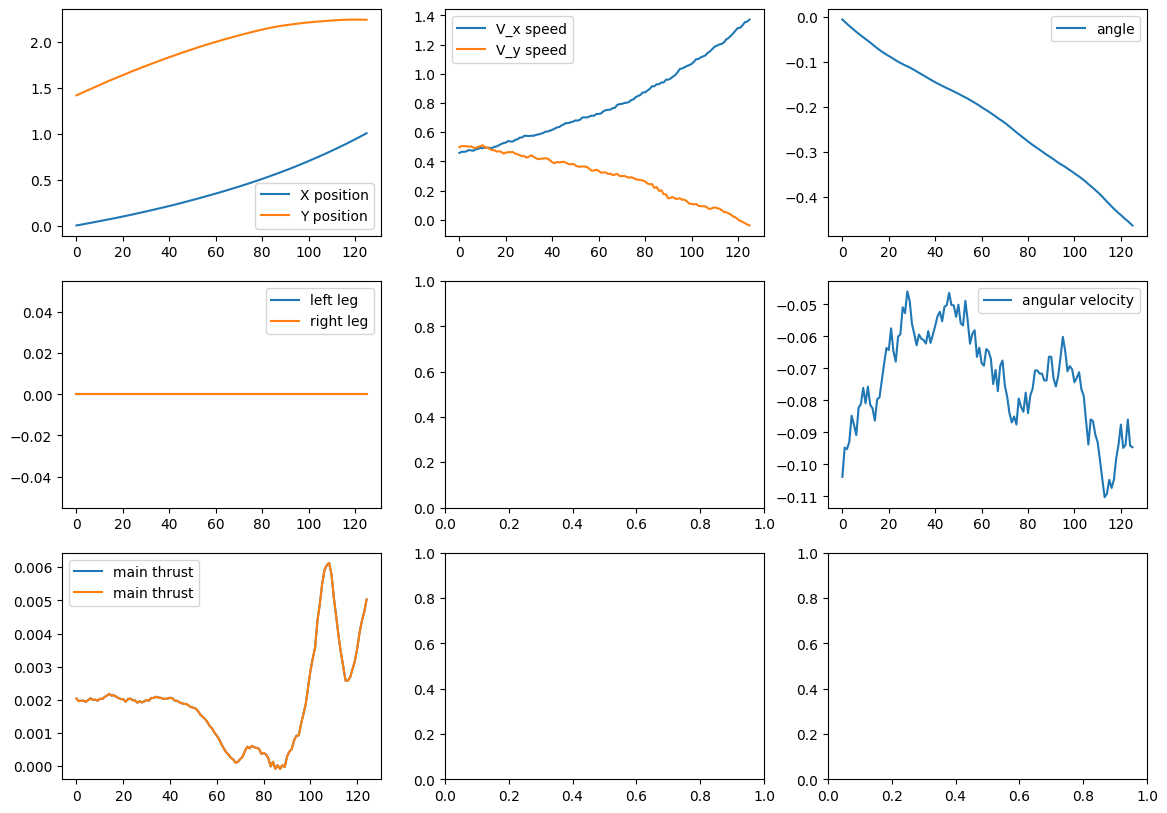

In [10]:
fig, axis = plt.subplots(3,3, figsize=(14,10))
axis[0, 0].plot([i[0] for i in X], label="X position")
axis[0, 0].plot([i[1] for i in X], label="Y position")
axis[0, 0].legend()

axis[0, 1].plot([i[2] for i in X], label="V_x speed")
axis[0, 1].plot([i[3] for i in X], label="V_y speed")
axis[0, 1].legend()

axis[0,2].plot([i[4] for i in X], label="angle")
axis[0,2].legend()

axis[1,2].plot([i[5] for i in X], label="angular velocity")
axis[1,2].legend()

axis[1,0].plot([i[6] for i in X], label="left leg")
axis[1,0].plot([i[7] for i in X], label="right leg")
axis[1,0].legend()

axis[2,0].plot([i[0] for i in U], label="main thrust")
axis[2,0].legend()
axis[2,1].plot([i[1] for i in U], label="lat thrust")
axis[2,1].legend()

axis[2,2].plot(e_model)
axis[2,2].legend()